In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix, f1_score, classification_report, recall_score, roc_curve
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import psycopg2
from config import *

from datetime import timedelta

import utm
import time

import glob

#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import class_weight
import optuna
from optuna import trial as trial

import seaborn as sns

In [2]:
conexion = psycopg2.connect(database=db_database, 
                                user=db_user, 
                                password=db_password, 
                                host=db_host, 
                                port=db_port)

In [3]:
fechaHasta='2023-01-01'
pathModelos = '/data/proyectos/GRAPEVINE/Models/fjlacueva/Phenology/ANN'
query="select * from public.sabana_sin_rad where fecha <= '"+ fechaHasta + "';"
sabana = pd.read_sql_query(query, con=conexion).drop_duplicates()
sabana

,phenologystageid,variedad,codigo,longitude,latitude,altitud,doc_id,fecha,estacion,season,...,do_Borja,do_Calatayud,do_Cariñena,do_Somontano,variedad_CABERNET SAUVIGNON,variedad_CHARDONNAY,variedad_GARNACHA,variedad_MAZUELA,variedad_SYRACH,variedad_TEMPRANILLO
0,0.0,GARNACHA,50004A03200057,-1.284122,41.332883,686.0,Cariñena,2016-01-05,Z01,2015_2016,...,0,0,1,0,0,0,1,0,0,0
1,0.0,TEMPRANILLO,50004A02500051,-1.253609,41.357499,587.0,Cariñena,2016-01-05,Z01,2015_2016,...,0,0,1,0,0,0,0,0,0,1
2,0.0,GARNACHA,50073A03200052,-1.231152,41.350539,578.0,Cariñena,2016-01-05,Z01,2015_2016,...,0,0,1,0,0,0,1,0,0,0
3,0.0,MAZUELA,50201A00200124,-1.225159,41.293432,702.0,Cariñena,2016-01-05,Z01,2015_2016,...,0,0,1,0,0,0,0,1,0,0
4,0.0,GARNACHA,50004A03200057,-1.284122,41.332883,686.0,Cariñena,2016-01-06,Z01,2015_2016,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104630,0.0,GARNACHA,50037A01500059,-1.565603,41.150106,868.0,Calatayud,2022-12-29,Z18,2022_2023,...,0,1,0,0,0,0,1,0,0,0
104631,0.0,GARNACHA,50037A01500059,-1.565603,41.150106,868.0,Calatayud,2022-12-30,Z18,2022_2023,...,0,1,0,0,0,0,1,0,0,0
104632,0.0,GARNACHA,50037A01500059,-1.565603,41.150106,868.0,Calatayud,2022-12-31,Z18,2022_2023,...,0,1,0,0,0,0,1,0,0,0
104633,0.0,GARNACHA,50037A01500059,-1.565603,41.150106,868.0,Calatayud,2023-01-01,Z18,2022_2023,...,0,1,0,0,0,0,1,0,0,0


In [4]:
sabana['doc_id']=sabana.doc_id.fillna('New')

In [5]:
sabana.doc_id.value_counts()

Cariñena     68387
Borja        28918
Calatayud     7141
Somontano      189
Name: doc_id, dtype: int64

In [8]:
parcelas_train=[]
parcelas_test=[]
parcelas_vali=[]
for do in sabana.doc_id.unique():
    print(do)
    parcelas_do_train, parcelas_do_no=train_test_split(list(sabana[sabana.doc_id==do].codigo.unique()),
                                                       random_state=17,test_size=0.4)
    parcelas_train=parcelas_train+parcelas_do_train
    if len(parcelas_do_no)>1:
        parcelas_do_vali, parcelas_do_test=train_test_split(parcelas_do_no,test_size=0.5, random_state=17)
        parcelas_train=parcelas_train+parcelas_do_train
        parcelas_test=parcelas_test+parcelas_do_test
        parcelas_vali=parcelas_vali+parcelas_do_vali
    else:
        pascelas_test=parcelas_test+parcelas_do_no

Cariñena
Borja
Calatayud
Somontano


In [9]:
temp=sabana.copy()
datos_list=[]
for id_terr in temp.codigo.unique():
    datos_camp_terr=temp[temp['codigo']==id_terr]
    datos_camp_terr['next_fecha']=datos_camp_terr['fecha'].shift(-7)
    datos_camp_terr['next_pheno']=datos_camp_terr['phenologystageid'].shift(-7)
    datos_camp_terr=datos_camp_terr[(datos_camp_terr.next_fecha-datos_camp_terr.fecha).dt.days==7]
    datos_list.append(datos_camp_terr)
datos_total=pd.concat(datos_list).reset_index(drop=True)
datos_total

/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,phenologystageid,variedad,codigo,longitude,latitude,altitud,doc_id,fecha,estacion,season,...,do_Cariñena,do_Somontano,variedad_CABERNET SAUVIGNON,variedad_CHARDONNAY,variedad_GARNACHA,variedad_MAZUELA,variedad_SYRACH,variedad_TEMPRANILLO,next_fecha,next_pheno
0,0.0,GARNACHA,50004A03200057,-1.284122,41.332883,686.0,Cariñena,2016-01-05,Z01,2015_2016,...,1,0,0,0,1,0,0,0,2016-01-12,0.0
1,0.0,GARNACHA,50004A03200057,-1.284122,41.332883,686.0,Cariñena,2016-01-06,Z01,2015_2016,...,1,0,0,0,1,0,0,0,2016-01-13,0.0
2,0.0,GARNACHA,50004A03200057,-1.284122,41.332883,686.0,Cariñena,2016-01-07,Z01,2015_2016,...,1,0,0,0,1,0,0,0,2016-01-14,0.0
3,0.0,GARNACHA,50004A03200057,-1.284122,41.332883,686.0,Cariñena,2016-01-08,Z01,2015_2016,...,1,0,0,0,1,0,0,0,2016-01-15,0.0
4,0.0,GARNACHA,50004A03200057,-1.284122,41.332883,686.0,Cariñena,2016-01-09,Z01,2015_2016,...,1,0,0,0,1,0,0,0,2016-01-16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80476,10.0,CHARDONNAY,22196A00100148,-0.101093,42.094222,481.0,Somontano,2020-08-16,gv05,2019_2020,...,0,1,0,1,0,0,0,0,2020-08-23,10.0
80477,10.0,CHARDONNAY,22196A00100148,-0.101093,42.094222,481.0,Somontano,2020-08-17,gv05,2019_2020,...,0,1,0,1,0,0,0,0,2020-08-24,10.0
80478,10.0,CHARDONNAY,22196A00100148,-0.101093,42.094222,481.0,Somontano,2020-08-18,gv05,2019_2020,...,0,1,0,1,0,0,0,0,2020-08-25,10.0
80479,10.0,CHARDONNAY,22196A00100148,-0.101093,42.094222,481.0,Somontano,2020-08-19,gv05,2019_2020,...,0,1,0,1,0,0,0,0,2020-08-26,10.0


In [10]:
conexion.close()

In [11]:
def eval_model(model,model_chars,train, vali, test):
    variedades=[col for col in train.columns if 'variedad_' in col]
    dos=[col for col in train.columns if 'do_' in col]
    variables_basic=['phenologystageid','dia', 'min', 'max', 'mean', 'std', 'median','diff']+variedades+dos
    medidas=variables_basic
    
    altitud=model_chars['params_Altitud']
    latitud=model_chars['params_Latitud']
    longitud=model_chars['params_Longitud']
    if(longitud):
        medidas.append('longitude')
    if(latitud):
        medidas.append('latitude')
    if(altitud):
        medidas.append('altitud')
        
    if ( model_chars['params_Acumuladas']):
        
        inicio=trial.suggest_categorical('Inicio mediciones',['t0','1','2'])
        suffix=''
        name_vars=[]
        
        chilling=trial.suggest_categorical('Chilling',[True,False])
        winkler=trial.suggest_categorical('Winkler',[True,False])
        gdd=trial.suggest_categorical('gdd',[True,False])
        
        acumulativo=trial.suggest_categorical('Acumulativo',[True,False])
        if (acumulativo):
            suffix='_Cumm'
            if(trial.suggest_categorical('Precipitaciones',[True,False])):
                name_vars.append('precip__'+inicio+'_')
                
        if (winkler|gdd):
            tbase=trial.suggest_categorical('Tbase',['Tbase','TbaseMax'])
            temperatura_inicio=trial.suggest_categorical('Temperatura inicio',['10.0','4.5'])
        if (chilling):
            tbase_chill=trial.suggest_categorical('Tbase_chilling',['Tbase','Tbasemin','Utah'])
            name_vars.append('chillingDD_7.0_'+inicio+'_' + tbase_chill +'_sum')
        if (winkler):
            if acumulativo:
                name_vars.append('winkler_'+temperatura_inicio+'_'+inicio+'_' + tbase)
            else:
                name_vars.append('winkler_'+temperatura_inicio+'_' + tbase)
        if (gdd):
            name_vars.append('gdd_'+temperatura_inicio+'_'+inicio+'_' + tbase+'_sum')
       
        if len(name_vars)>0:
            semanas_list=[]
            for i in range(1,3):
                if(trial.suggest_categorical(str(i)+'_semanas_atras',[True,False])):
                    semanas_list.append(' '+str(i)+'_semanas_atras')
            if(trial.suggest_categorical('1_semanas_adelante',[True,False])):
                    semanas_list.append(' 1_semanas_adelante')
                    
            for name_var in name_vars:
                medidas.append(name_var+suffix)
                for semana in semanas_list:
                    medidas.append(name_var+suffix+semana)
        
    else:
        name_vars=[]    
        if(trial.suggest_categorical('Temperatura',[True,False])):
            if(trial.suggest_categorical('Temperatura_media',[True,False])):
                name_vars.append('tmed_mean')
            if(trial.suggest_categorical('Temperatura_min',[True,False])):
                name_vars.append('tmed_min')
            if(trial.suggest_categorical('Temperatura_max',[True,False])):
                name_vars.append('tmed_max')

        if(trial.suggest_categorical('Viento',[True,False])):
            if(trial.suggest_categorical('Viento_norte',[True,False])):
                name_vars.append('wind_N')
            if(trial.suggest_categorical('Viento_noreste',[True,False])):
                name_vars.append('wind_NE')
            if(trial.suggest_categorical('Viento_este',[True,False])):
                name_vars.append('wind_E')
            if(trial.suggest_categorical('Viento_sureste',[True,False])):
                name_vars.append('wind_SE')
            if(trial.suggest_categorical('Viento_sur',[True,False])):
                name_vars.append('wind_S')
            if(trial.suggest_categorical('Viento_suroeste',[True,False])):
                name_vars.append('wind_SW')
            if(trial.suggest_categorical('Viento_oeste',[True,False])):
                name_vars.append('wind_W')
            if(trial.suggest_categorical('Viento_noroeste',[True,False])):
                name_vars.append('wind_NW')
        
        if len(name_vars)>0:
            dias_vars=[]
            for i in range(1,14):
                if(trial.suggest_categorical(str(i)+'_dias_atras',[True,False])):
                    dias_vars.append(' ' + str(i) + '_dias_atras')
            for i in range(1,7):
                if(trial.suggest_categorical(str(i)+'_dias_adelante',[True,False])):
                    dias_vars.append(' ' + str(i) + '_dias_adelante')

            for name_var in name_vars:
                medidas.append(name_var)
                for dia_var in dias_vars:
                    medidas.append(name_var+dia_var)

    medidas.append('next_pheno')
    train=train[medidas].dropna()
    vali=vali[medidas].dropna()
    print(len(medidas))
    
    weights=class_weight.compute_class_weight('balanced', classes=np.asarray(range(0,11)), 
                                      y=np.hstack([range(0,11),train['next_pheno'].values]))


    X_train=train.drop(['next_pheno'], axis=1).values
    X_vali=vali.drop(['next_pheno'], axis=1).values
    Y_vali=vali['next_pheno'].values
    Y_train=pd.get_dummies(np.hstack([range(0,11),train['next_pheno'].values]))[11:].values

    if 'system_attrs_Umbral' in model_chars.index:
        umbral=float(model_chars['system_attrs_Umbral'])
    else: umbral=0.5
    
    preds_proba=model.predict(X_vali)
    SCORE=roc_auc_score(Y_vali,preds_proba)
    print(min(preds_proba))
    print(max(preds_proba))
    preds = preds_proba>umbral
    mcc=matthews_corrcoef(Y_vali,preds)
    print("MCC: ",mcc)
    print("Accuracy: ", accuracy_score(Y_vali,preds))
    print("F1-score: ", f1_score(Y_vali,preds))
    print("Recall:", recall_score(Y_vali,preds))
    print("Summary:")
    print(classification_report(Y_vali,preds))
    
    fpr, tpr, _ = roc_curve(Y_vali,  preds_proba)

    #create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    '''pasos=np.arange(min(preds_proba),max(preds_proba),step=(max(preds_proba)-min(preds_proba))/30.0)
    for paso in pasos:
        print('#'*10)
        print('Treshold:',paso)
        preds = (preds_proba>paso)*1.0
        print("Accuracy: ", accuracy_score(Y_vali,preds))
        print("F1-score: ", f1_score(Y_vali,preds))
        print("Recall:", recall_score(Y_vali,preds))
        print("Confussion matrix:")
        print(confusion_matrix(Y_vali,preds))
    '''
    return SCORE, medidas, preds

In [12]:
train=datos_total[datos_total.codigo.isin(parcelas_train)]
vali=datos_total[datos_total.codigo.isin(parcelas_vali)]
test=datos_total[datos_total.codigo.isin(parcelas_test)]
train=train.drop(columns=['codigo','fecha'])
vali=vali.drop(columns=['codigo','fecha'])
test=test.drop(columns=['codigo','fecha'])

In [16]:
from keras.models import model_from_json
from keras.backend import clear_session
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.models import Sequential, load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix, f1_score, classification_report, recall_score, roc_curve
os.environ["CUDA_VISIBLE_DEVICES"]="1"


mejor_modelo={}

modelos_estado=pd.read_csv(pathModelos+f'/resumen_optuna-fenologia-nn-mcc-parcelas.csv')
modelos_estado=modelos_estado.sort_values('value',ascending=False)
modelo_elegido=modelos_estado.iloc[1]
modelo_elegido=modelos_estado.iloc[0]

mejor_modelo['params']=modelo_elegido

print(modelo_elegido.value)
json_file = open(glob.glob((pathModelos+f'/model-fenologia-'+str(modelo_elegido['value'])[:10])+'*.json')[0], 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
#model.load_weights(glob.glob(pathModelos+f'/model-fenologia-'+str(modelo_elegido['value'])[:10]+'*.h5')[0])
#mejor_modelo['modelo']=model

#print(modelo_elegido['value'])
#mejor_modelo['value'], mejor_modelo['medidas']=eval_model(model,modelo_elegido,temp)


0.2992659841522803


In [17]:
print(pathModelos+'/'+str(modelo_elegido['value'])[:10]+'*.h5')

/data/proyectos/GRAPEVINE/Models/fjlacueva/Phenology/ANN/0.29926598*.h5


In [18]:
#model.load_weights(glob.glob(pathModelos+f'/model-fenologia-'+str(modelo_elegido['value'])[:10]+'*.h5')[0])
model.load_weights(glob.glob(pathModelos+ '/model-fenologia-'+ str(modelo_elegido['value'])[:10]+'*.h5')[0])

In [19]:
def eval_model2(model, model_chars,train,vali):
    variedades=[col for col in train.columns if 'variedad_' in col]
    dos=[col for col in train.columns if 'do_' in col]
    variables_basic=['phenologystageid','dia', 'min', 'max', 'mean', 'std', 'median','diff']+variedades+dos
    medidas=variables_basic
    
    altitud=model_chars['params_Altitud']
    latitud=model_chars['params_Latitud']
    longitud=model_chars['params_Longitud']
    if(longitud):
        medidas.append('longitude')
    if(latitud):
        medidas.append('latitude')
    if(altitud):
        medidas.append('altitud')
        
    if model_chars['params_Acumuladas']:

        inicio=model_chars['params_Inicio mediciones']
        suffix=''
        name_vars=[]
        
        chilling=model_chars['params_Chilling']
        winkler=model_chars['params_Winkler']
        gdd=model_chars['params_gdd']
        
        acumulativo=model_chars['params_Acumulativo']
        if (acumulativo):
            suffix='_Cumm'
            if model_chars['params_Precipitaciones']:
                name_vars.append('precip__'+inicio+'_')
#             if model_chars['params_Radiacion']:
#                 name_vars.append('rad__'+inicio+'_')
                
        if (winkler|gdd):
            tbase=model_chars['params_Tbase']
            temperatura_inicio=str(model_chars['params_Temperatura inicio'])
        if (chilling):
            tbase_chill=model_chars['params_Tbase_chilling']
            name_vars.append('chillingDD_7.0_'+inicio+'_' + tbase_chill +'_sum')
        if (winkler):
            if acumulativo:
                name_vars.append('winkler_'+temperatura_inicio+'_'+inicio+'_' + tbase)
            else:
                name_vars.append('winkler_'+temperatura_inicio+'_' + tbase)
        if (gdd):
            name_vars.append('gdd_'+temperatura_inicio+'_'+inicio+'_' + tbase+'_sum')
       
        if len(name_vars)>0:
            semanas_list=[]
            for i in range(1,3):
                if model_chars['params_'+str(i)+'_semanas_atras']:
                    semanas_list.append(' '+str(i)+'_semanas_atras')
            if model_chars['params_1_semanas_adelante']:
                    semanas_list.append(' 1_semanas_adelante')
                    
            for name_var in name_vars:
                medidas.append(name_var+suffix)
                for semana in semanas_list:
                    medidas.append(name_var+suffix+semana)
        
    else:
        name_vars=[]    
        if model_chars['params_Temperatura']:
            if model_chars['params_Temperatura_media']:
                name_vars.append('tmed_mean')
            if model_chars['params_Temperatura_min']:
                name_vars.append('tmed_min')
            if model_chars['params_Temperatura_max']:
                name_vars.append('tmed_max')

        if model_chars['params_Viento']:
            if model_chars['params_Viento_norte']:
                name_vars.append('wind_N')
            if model_chars['params_Viento_noreste']:
                name_vars.append('wind_NE')
            if model_chars['params_Viento_este']:
                name_vars.append('wind_E')
            if model_chars['params_Viento_sureste']:
                name_vars.append('wind_SE')
            if model_chars['params_Viento_sur']:
                name_vars.append('wind_S')
            if model_chars['params_Viento_suroeste']:
                name_vars.append('wind_SW')
            if model_chars['params_Viento_oeste']:
                name_vars.append('wind_W')
            if model_chars['params_Viento_noroeste']:
                name_vars.append('wind_NW')
        
        if len(name_vars)>0:
            dias_vars=[]
            for i in range(1,14):
                if model_chars['params_'+str(i)+'_dias_atras']:
                    dias_vars.append(' ' + str(i) + '_dias_atras')
            for i in range(1,7):
                if model_chars['params_'+str(i)+'_dias_adelante']:
                    dias_vars.append(' ' + str(i) + '_dias_adelante')

            for name_var in name_vars:
                medidas.append(name_var)
                for dia_var in dias_vars:
                    medidas.append(name_var+dia_var)

    medidas.append('next_pheno')
    
    train=train[medidas].dropna()
    vali=vali[medidas].dropna()             
    
    X_train=train.drop(['next_pheno'], axis=1).values
    Y_train=train['next_pheno'].values
    X_vali=vali.drop(['next_pheno'], axis=1).values
    Y_vali=vali['next_pheno'].values
    
    #model=load_model(pathModelos+'/checkpointed_model.h5')
        
    probs=model.predict(X_vali)
    preds=np.argmax(probs,axis=1)+1
    mcc=matthews_corrcoef(Y_vali,preds)
    print("MCC: ",mcc)
    print("Accuracy: ", accuracy_score(Y_vali,preds))
    SCORE=mcc
    
    mcc=matthews_corrcoef(Y_vali,preds)
    print("MCC: ",mcc)
    print("Accuracy: ", accuracy_score(Y_vali,preds))
#     print("F1-score: ", f1_score(Y_vali,preds))
    print("Confussion matrix:")
    print(confusion_matrix(Y_vali,preds))
    print("Summary:")
    print(classification_report(Y_vali,preds))
    
    cf_matrix=confusion_matrix(vali['next_pheno'],preds)
    cf_matrix=cf_matrix.T/cf_matrix.sum(axis=1)
    
    sns.heatmap(cf_matrix.T, annot=True)
    plt.show()
    
    return model, medidas

Unnamed: 0                                        1243
number                                            1243
value                                         0.299266
datetime_start              2023-10-07 08:02:15.973763
datetime_complete           2023-10-07 08:02:43.631114
                                       ...            
params_Viento_suroeste                             NaN
params_Winkler                                   False
params_gdd                                        True
system_attrs_fail_reason                           NaN
state                                         COMPLETE
Name: 1243, Length: 476, dtype: object

MCC:  0.26392856522703434
Accuracy:  0.2435364727608495
MCC:  0.26392856522703434
Accuracy:  0.2435364727608495
Confussion matrix:
[[   0 7688    0    0    0  724    0    0    0    0   10]
 [   0  733    0    0    0    0    0    0    0    0    0]
 [   0  518    0    0    0   48    0    0    0    0    0]
 [   0  843    0    0    0  554    0    0    0    

/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

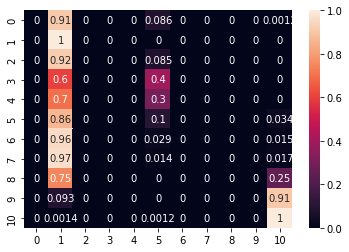

In [20]:
mejor_modelo['modelo']=model
print(modelo_elegido)
print(model)
#mejor_modelo['value'], mejor_modelo['medidas']=eval_model(model,modelo_elegido,train, vali, test)
mejor_modelo['value'], mejor_modelo['medidas']=eval_model2(model, modelo_elegido,train, test)


In [21]:

print(modelo_elegido.keys())
for key in modelo_elegido.keys():
    print(key + ": " + str(modelo_elegido[key]))

Index(['Unnamed: 0', 'number', 'value', 'datetime_start', 'datetime_complete',
       'duration', 'params_10_dias_atras', 'params_11_dias_atras',
       'params_12_dias_atras', 'params_13_dias_atras',
       ...
       'params_Viento_noroeste', 'params_Viento_norte', 'params_Viento_oeste',
       'params_Viento_sur', 'params_Viento_sureste', 'params_Viento_suroeste',
       'params_Winkler', 'params_gdd', 'system_attrs_fail_reason', 'state'],
      dtype='object', length=476)
Unnamed: 0: 1243
number: 1243
value: 0.2992659841522803
datetime_start: 2023-10-07 08:02:15.973763
datetime_complete: 2023-10-07 08:02:43.631114
duration: 0 days 00:00:27.657351
params_10_dias_atras: nan
params_11_dias_atras: nan
params_12_dias_atras: nan
params_13_dias_atras: nan
params_1_dias_adelante: nan
params_1_dias_atras: nan
params_1_semanas_adelante: False
params_1_semanas_atras: False
params_2_dias_adelante: nan
params_2_dias_atras: nan
params_2_semanas_atras: False
params_3_dias_adelante: nan
params_3_d

In [16]:
print(modelo_elegido)

In [27]:
# load weights into new model
#model.load_weights(glob.glob('/data/proyectos/GRAPEVINE/Models/sabana_completa/'+carpeta+'/Lobesia/model-lobesia-'+str(modelo_elegido['value'])[:10]+'*.h5')[0])
model.load_weights(glob.glob('/'+ str(modelo_elegido['value'])[:10]+'*.h5')[0])
mejor_modelo['modelo']=model

print(modelo_elegido['value'])
mejor_modelo['value'], mejor_modelo['medidas']=eval_model(model,modelo_elegido,temp)

NameError: name 'carpeta' is not defined

In [ ]:
print('Validation')
eval_model(modelo_elegido,train,vali)

In [ ]:
print('Test')
model, medidas=eval_model(modelo_elegido,train,test)

In [ ]:
test['next_pheno'].value_counts()

In [ ]:
recalls=[]
f1s=[]
precissions=[]

In [ ]:
import json
import pickle

dic_info={'type':'GB','measures':medidas}
with open(pathModelos+'piral_info.json', 'w') as fp:
    json.dump(dic_info, fp)

# open a file, where you ant to store the data
file = open(path_to_models+'piral.pkl', 'wb')

# dump information to that file
pickle.dump(model, file)

# close the file
file.close()

In [ ]:
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df.iloc[:20]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES') 

In [ ]:
medidas

In [ ]:
plot_feature_importance(model.feature_importances_,medidas[:-1],'RANDOM FOREST')

In [ ]:
modelos_estado.iloc[:1000][['params_Altitud','params_Latitud', 'params_Longitud']].sum().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_Acumuladas', 'params_Acumulativo', 'params_Chilling']].sum().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_Precipitaciones', 'params_Radiacion', 'params_Radiacion_max',
       'params_Radiacion_media', 'params_Radiacion_min', 'params_Tbase','params_Temperatura','params_Temperatura_max',
       'params_Temperatura_media', 'params_Temperatura_min', 'params_Viento',
       'params_Viento_este', 'params_Viento_noreste', 'params_Viento_noroeste',
       'params_Viento_norte', 'params_Viento_oeste', 'params_Viento_sur',
       'params_Viento_sureste', 'params_Viento_suroeste', 'params_Winkler',
       'params_gdd']].sum().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_Neuronas capa 0', 'params_Neuronas capa 1',
       'params_Neuronas capa 2', 'params_Neuronas capa 3',
       'params_Neuronas capa 4', 'params_Neuronas capa 5',
       'params_Neuronas capa 6', 'params_Neuronas capa 7',
       'params_Neuronas capa 8', 'params_Neuronas capa 9']].mean().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_2_semanas_atras','params_1_semanas_atras','params_1_semanas_adelante']].sum().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_13_dias_atras','params_12_dias_atras','params_11_dias_atras','params_10_dias_atras',
                            'params_9_dias_atras','params_8_dias_atras','params_7_dias_atras','params_6_dias_atras',
                            'params_5_dias_atras','params_4_dias_atras','params_3_dias_atras','params_2_dias_atras',
                            'params_1_dias_atras','params_1_dias_adelante', 'params_2_dias_adelante',
                            'params_3_dias_adelante','params_4_dias_adelante','params_5_dias_adelante',
                            'params_6_dias_adelante']].sum().plot(kind='bar')

In [ ]:
#modelo_elegido.to_csv('/data/proyectos/GRAPEVINE/Models/best_models/diseases/Oidio.csv')
modelo_elegido.to_csv('/data/proyectos/GRAPEVINE/Models/best_models/diseases/Oidio.csv')
#nombre='/data/proyectos/GRAPEVINE/Models/best_models/diseases/Oidio'
nombre=pathModelos + '/'
     
model_json = model.to_json()
with open(nombre+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(nombre+".h5")

In [ ]:
modelos_estado